In [1]:
from PIL import Image
from vangogh.evolution import Evolution
from vangogh.fitness import draw_voronoi_image
from vangogh.util import IMAGE_SHRINK_SCALE, REFERENCE_IMAGE
from vangogh.evaluation import *
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.axes_grid1 import ImageGrid
plt.style.use('classic')
%matplotlib inline

from multiprocess import Pool, cpu_count
import sys
import csv
import seaborn as sns


# Enable to show live rendering of best individual during optimization
display_output = False
# Enable to save progress images at every 50th generation
save_progress = True
# Enable to print verbose output per generation
verbose_output = True

def reporter(time, evo):
    if save_progress or display_output:
        elite = draw_voronoi_image(evo.elite, evo.reference_image.width, evo.reference_image.height, scale=IMAGE_SHRINK_SCALE)
    if display_output:
        clear_output()
        display(elite)
    if save_progress and time["num-generations"] % 50 == 0:
        elite.save(f"./img/van_gogh_intermediate_{evo.seed}_{evo.population_size}_{evo.crossover_method}_{evo.num_points}_{evo.initialization}_{evo.generation_budget}_{time['num-generations']:05d}.png")
        

def run_algorithm(settings):
    population_size, generation_budget, crossover_method, mutation_method, mutation_probability, \
        mutation_candidate_size, optimize_color, optimize_color_method, selection_name, initialization = settings

    output_file = f"./output/{population_size}_{generation_budget}_{crossover_method}_{mutation_method}_{mutation_probability}_{mutation_candidate_size}_{optimize_color}_{optimize_color_method}_{selection_name}_{initialization}.txt"
    with open(output_file, "w") as f:
        original_stdout = sys.stdout
        sys.stdout = f

#         print("population_size, generation_budget, crossover_method, mutation_method, mutation_probability, mutation_candidate_size, optimize_color, optimize_color_method, selection_name, initialization")
#         print(settings)
    
        start = time()
        data = []
        evo = Evolution(100, # num_points, # use only 100 or 50, use 50 will make our life easier
                        REFERENCE_IMAGE,
                        # evolution_type='p+o',
                        population_size=population_size,
                        generation_budget=generation_budget,
                        # evaluation_budget=-1,
                        crossover_method=crossover_method,
                        mutation_method=mutation_method,
                        mutation_probability=mutation_probability, # default 'inv_genotype_length'
                        num_features_mutation_strength=.25, # only in DEFAULT mutation_method
                        # num_features_mutation_strength_decay=None,
                        # num_features_mutation_strength_decay_generations=None,
                        mutation_candidate_size=mutation_candidate_size,  # doesn't matter for DEFAULT mutation_method
                        optimize_color=optimize_color,
                        optimize_color_method=optimize_color_method, # "AVERAGE", "DOMINANT", or "COORD"; whatever when optimize_color==False
                        selection_name=selection_name, # tournament_4 was the original
                        initialization=initialization, # initialization method
                        # noisy_evaluations=False,
                        verbose=True,
                        generation_reporter=reporter,
                        seed=0)
        data = evo.run(9)
        time_spent = time() - start
        print(f"Time spent: {time_spent} seconds")

        sys.stdout = original_stdout
        
        return data

        
# population_size, generation_budget, crossover_method, mutation_method, mutation_probability, \
#         mutation_candidate_size, optimize_color, optimize_color_method, initialization
def get_settings(population_size=100, generation_budget=500, crossover_method="ONE_POINT", 
                 mutation_method="DEFAULT", mutation_probability='inv_genotype_length',
                 mutation_candidate_size=5, optimize_color=False, optimize_color_method="AVERAGE", 
                 selection_name='tournament_2', initialization="RANDOM"):
    
#     print(f"population_size={population_size}, generation_budget={generation_budget}, crossover_method={crossover_method}, \
#           mutation_method={mutation_method}, mutation_probability={mutation_probability}, mutation_candidate_size={mutation_candidate_size}, \
#           optimize_color={optimize_color}, optimize_color_method={optimize_color_method}, \
#           selection_name={selection_name}, initialization={initialization}")
    
    return (population_size, generation_budget, crossover_method, mutation_method, mutation_probability, 
            mutation_candidate_size, optimize_color, optimize_color_method, selection_name, initialization)

In [2]:
random   = run_algorithm(get_settings(generation_budget=1, initialization="RANDOM"))
coord    = run_algorithm(get_settings(generation_budget=1, initialization="PICK_SINGLE_COORD_COLOR"))
average  = run_algorithm(get_settings(generation_budget=1, initialization="PICK_AVERAGE_CELL_COLOR"))
dominant = run_algorithm(get_settings(generation_budget=1, initialization="PICK_DOMINANT_CELL_COLOR"))

# data_random   = random[0]['all-fitnesses']
# data_coord    = coord[0]['all-fitnesses']
# data_average  = average[0]['all-fitnesses']
# data_dominant = dominant[0]['all-fitnesses']

data_fig1 = [random, coord, average, dominant]
with open("./output/init_rcad__ind_fig1.txt", "w") as f:
    wr = csv.writer(f)
    wr.writerows(data_fig1)

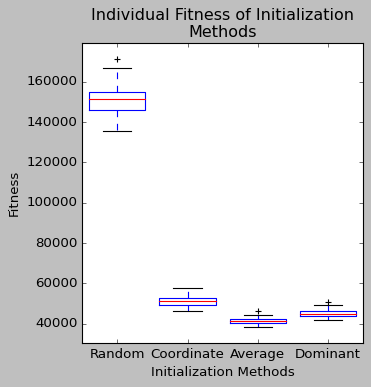

In [19]:
from textwrap import wrap

data = [random, coord, average, dominant]

fig, ax = plt.subplots(figsize=(4.8, 5))
ax.boxplot(data, widths=0.8)
ax.margins(y=0.06)
# ax.set_xlim(0-1, 1+1)

# fig, ax = plt.subplots()
# ax.boxplot(data)
ax.set_xticklabels(['Random', 'Coordinate', 'Average', 'Dominant'])

# Set the title and labels for the axes
ax.set_title("\n".join(wrap("Individual Fitness of Initialization Methods", 40)))

# ax.set_title('Individual Fitnesses of Random Initialization')
ax.set_xlabel('Initialization Methods')
ax.set_ylabel('Fitness')

# Display the plot
plt.tight_layout()
plt.show()

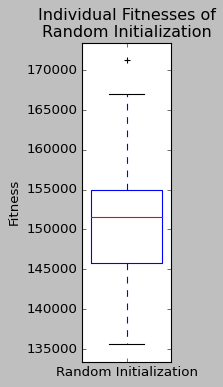

In [3]:
from textwrap import wrap

data = random

fig, ax = plt.subplots(figsize=(2.4, 5))
ax.boxplot(data, widths=0.8)
ax.margins(y=0.06)
# ax.set_xlim(0-1, 1+1)

# fig, ax = plt.subplots()
# ax.boxplot(data)
ax.set_xticklabels(['Random Initialization'])

# Set the title and labels for the axes
ax.set_title("\n".join(wrap("Individual Fitnesses of Random Initialization", 25)))

# ax.set_title('Individual Fitnesses of Random Initialization')
# ax.set_xlabel('Ramdon Initialization')
ax.set_ylabel('Fitness')

# Display the plot
plt.tight_layout()
plt.show()

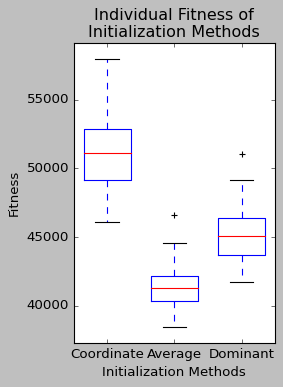

In [20]:
from textwrap import wrap

data = [coord, average, dominant]

fig, ax = plt.subplots(figsize=(3.7, 5))
ax.boxplot(data, widths=0.7)
ax.margins(y=0.06)

# fig, ax = plt.subplots()
# ax.boxplot(data)
ax.set_xticklabels(['Coordinate', 'Average', 'Dominant'])

# Set the title and labels for the axes
ax.set_title("\n".join(wrap("Individual Fitness of Initialization Methods", 35)))

# ax.set_title('Individual Fitnesses of Initialization Methods')
ax.set_xlabel('Initialization Methods')
ax.set_ylabel('Fitness')

# Display the plot
plt.tight_layout()
plt.show()

In [6]:
# box plot of the best fitness in each population of size 100 after initialization using different methods over 10 runs

runs = 100 

def generate_data(init):
    print("starting ", init)
    best = []
    ave = []
    std = []
    for i in range(runs):
        besti, avei, stdi = run_algorithm(get_settings(generation_budget=1, initialization=init))
        best.append(besti)
        ave.append(avei)
        std.append(stdi)

    data = [best, ave, std]
    with open(f"./output/{init}__bas_fit.txt", "w") as f:
        wr = csv.writer(f)
        wr.writerows(data)
    print("done ", init)
    return data

inits = ["PICK_SINGLE_COORD_COLOR", "PICK_AVERAGE_CELL_COLOR", "PICK_DOMINANT_CELL_COLOR"]

coord_best, coord_ave, coord_std = generate_data("PICK_SINGLE_COORD_COLOR")
ave_best, ave_ave, ave_std = generate_data("PICK_AVERAGE_CELL_COLOR")
dom_best, dom_ave, dom_std = generate_data("PICK_DOMINANT_CELL_COLOR")
    

PICK_SINGLE_COORD_COLOR
PICK_AVERAGE_CELL_COLOR
PICK_DOMINANT_CELL_COLOR


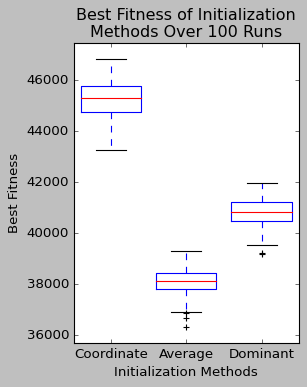

In [11]:
from textwrap import wrap 

data = [coord_best, ave_best, dom_best]

fig, ax = plt.subplots(figsize=(4, 5))
ax.boxplot(data, widths=0.8)
ax.margins(y=0.06)

# fig, ax = plt.subplots()
# ax.boxplot(data)
ax.set_xticklabels(['Coordinate', 'Average', 'Dominant'])

# Set the title and labels for the axes
ax.set_title("\n".join(wrap("Best Fitness of Initialization Methods Over 100 Runs", 35)))
ax.set_xlabel('Initialization Methods')
ax.set_ylabel('Best Fitness')

# Display the plot
plt.tight_layout()
plt.show()

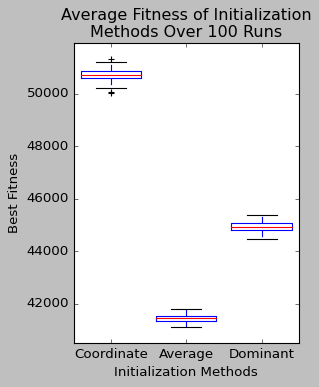

In [12]:
from textwrap import wrap 

data = [coord_ave, ave_ave, dom_ave]

fig, ax = plt.subplots(figsize=(4, 5))
ax.boxplot(data, widths=0.8)
ax.margins(y=0.06)

# fig, ax = plt.subplots()
# ax.boxplot(data)
ax.set_xticklabels(['Coordinate', 'Average', 'Dominant'])

# Set the title and labels for the axes
ax.set_title("\n".join(wrap("Average Fitness of Initialization Methods Over 100 Runs", 35)))
ax.set_xlabel('Initialization Methods')
ax.set_ylabel('Best Fitness')

# Display the plot
plt.tight_layout()
plt.show()

In [4]:
runs = 10

# time should be abour the same, so just best and average fitness

def generate_data(init):
    print("starting ", init)
    ret = []
    for i in range(runs):
        print("run ", i)
        data = run_algorithm(get_settings(initialization=init)) # over 500 generations
        ret.append(data)

    with open(f"./output/{init}__ba_fit_{runs}runs.txt", "w") as f:
        wr = csv.writer(f)
        wr.writerows(ret)
        
    print("done ", init)
    return ret

In [8]:
inits = ["RANDOM", "PICK_SINGLE_COORD_COLOR", "PICK_AVERAGE_CELL_COLOR", "PICK_DOMINANT_CELL_COLOR"]

random = generate_data("RANDOM")

starting  RANDOM
run  0
run  1
run  2
run  3
run  4
run  5
run  6
run  7
run  8
run  9
done  RANDOM


In [5]:
coord = generate_data("PICK_SINGLE_COORD_COLOR")

starting  PICK_SINGLE_COORD_COLOR
run  0
run  1
run  2
run  3
run  4
run  5
run  6
run  7
run  8
run  9
done  PICK_SINGLE_COORD_COLOR


In [6]:
ave = generate_data("PICK_AVERAGE_CELL_COLOR")

starting  PICK_AVERAGE_CELL_COLOR
run  0
run  1
run  2
run  3
run  4
run  5
run  6
run  7
run  8
run  9
done  PICK_AVERAGE_CELL_COLOR


In [7]:
dom = generate_data("PICK_DOMINANT_CELL_COLOR")

starting  PICK_DOMINANT_CELL_COLOR
run  0
run  1
run  2
run  3
run  4
run  5
run  6
run  7
run  8
run  9
done  PICK_DOMINANT_CELL_COLOR


In [31]:
rand_average = np.mean(np.array(random), axis=0)
rand_average_best = rand_average[:, 0]
rand_average_ave = rand_average[:, 1]

c_average = np.mean(np.array(coord), axis=0)
c_average_best = c_average[:, 0]
c_average_ave = c_average[:, 1]

a_average = np.mean(np.array(ave), axis=0)
a_average_best = a_average[:, 0]
a_average_ave = a_average[:, 1]

d_average = np.mean(np.array(dom), axis=0)
d_average_best = d_average[:, 0]
d_average_ave = d_average[:, 1]

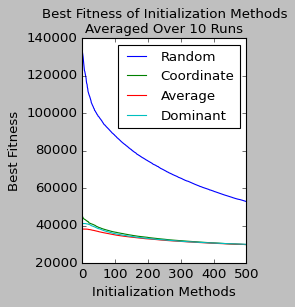

In [32]:
from textwrap import wrap 

x = [i for i in range(500)]

fig, ax = plt.subplots(figsize=(3.5, 4))
plt.plot(x, rand_average_best, label='Random')
plt.plot(x, c_average_best, label='Coordinate')
plt.plot(x, a_average_best, label='Average')
plt.plot(x, d_average_best, label='Dominant')


# Set the title and labels for the axes
ax.set_title("\n".join(wrap("Best Fitness of Initialization Methods Averaged Over 10 Runs", 40)), fontsize=12)
ax.set_xlabel('Initialization Methods')
ax.set_ylabel('Best Fitness')

# Display the plot
plt.tight_layout()
plt.legend(fontsize=12)
plt.show()

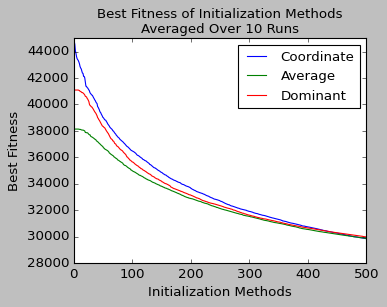

In [34]:
from textwrap import wrap 

x = [i for i in range(500)]

fig, ax = plt.subplots(figsize=(5, 4)) # change size of the image
plt.plot(x, c_average_best, label='Coordinate')
plt.plot(x, a_average_best, label='Average')
plt.plot(x, d_average_best, label='Dominant')

plt.ylim(28000, 45000) # restrict y sxis

# Set the title and labels for the axes
ax.set_title("\n".join(wrap("Best Fitness of Initialization Methods Averaged Over 10 Runs", 45)), fontsize=12) # change font size to make it more readable
ax.set_xlabel('Initialization Methods')
ax.set_ylabel('Best Fitness')

# Display the plot
plt.tight_layout()
plt.legend(fontsize=12) # change font size to make it more readable
plt.show()

In [3]:
# mutation baseline
runs = 10

print("starting")
ret = []
for i in range(runs):
    print("run ", i)
    data = run_algorithm(get_settings(initialization="PICK_AVERAGE_CELL_COLOR", population_size=24))
    ret.append(data)

with open(f"./output/mutation_base_pop_24.txt", "w") as f:
    wr = csv.writer(f)
    wr.writerows(ret)

print("done")
print(ret)

starting
run  0
run  1
run  2
run  3
run  4
run  5
run  6
run  7
run  8
run  9
done
[[38486, 38486, 38486, 38486, 38486, 38486, 38486, 38486, 38486, 38194, 38194, 38193, 38193, 38193, 38141, 38141, 38141, 38012, 38012, 38012, 38012, 37984, 37984, 37911, 37873, 37873, 37869, 37860, 37759, 37759, 37759, 37625, 37625, 37625, 37593, 37593, 37534, 37534, 37291, 37192, 37192, 37192, 37148, 37125, 37125, 37125, 37120, 37120, 37120, 37120, 37120, 37120, 37097, 37095, 37080, 37080, 36930, 36930, 36905, 36905, 36905, 36859, 36859, 36859, 36761, 36750, 36734, 36730, 36730, 36720, 36720, 36583, 36583, 36559, 36559, 36559, 36558, 36558, 36508, 36453, 36453, 36448, 36448, 36406, 36406, 36331, 36331, 36331, 36331, 36331, 36331, 36331, 36311, 36311, 36311, 36169, 36169, 36081, 36081, 36081, 36081, 36081, 35988, 35988, 35988, 35949, 35949, 35949, 35916, 35916, 35916, 35916, 35909, 35909, 35909, 35909, 35909, 35908, 35897, 35897, 35887, 35856, 35697, 35697, 35688, 35688, 35688, 35688, 35688, 35688, 3568

In [6]:
ave = np.mean(np.array(ret),axis=0)
print(ave)
print(len(ave))

[38931.1 38931.1 38899.2 38899.2 38899.2 38892.7 38892.7 38831.8 38831.8
 38796.8 38796.1 38796.  38738.2 38727.7 38719.1 38666.8 38642.  38605.1
 38589.6 38571.1 38484.5 38435.3 38367.6 38297.3 38260.2 38220.1 38181.6
 38122.8 38074.3 38033.7 38004.8 37983.3 37897.1 37886.3 37846.7 37826.4
 37799.  37784.3 37732.5 37704.2 37652.7 37647.5 37607.6 37563.5 37535.5
 37509.9 37475.4 37449.8 37426.2 37423.2 37387.8 37345.7 37335.7 37291.1
 37268.9 37245.9 37214.  37183.1 37160.7 37152.7 37145.8 37108.  37068.9
 37046.5 37026.6 37007.7 36992.4 36980.6 36936.7 36910.  36892.9 36841.5
 36831.  36824.6 36801.2 36794.7 36750.5 36721.3 36712.6 36679.7 36651.3
 36640.5 36620.5 36601.2 36586.8 36556.7 36541.  36513.1 36436.2 36394.2
 36386.2 36357.8 36354.2 36330.2 36305.7 36277.  36263.  36240.8 36233.5
 36217.5 36206.1 36168.8 36153.  36140.  36125.6 36112.9 36083.7 36060.1
 36053.6 36009.2 35987.8 35982.5 35942.6 35929.3 35901.2 35891.6 35885.9
 35876.6 35857.2 35840.1 35815.9 35769.2 35731.2 35